# Zadanie 2

Celem pracy jest wyznaczenie prognozy sprzedaży trzech produktów na 6 okresów do przodu. Aby predykcja sprzedaży w jak największym stopniu odzwierciedlała zastaną przyszłość postanowiono przeprowadzić prognozy dla każdego produktu osobno, a następnie dokonać agregacji produktów. Do budowy modeli predykcyjnych wykorzystano 4 metody prognozowania: metodę ARIMA, SARIMA, Model Holta-Wintersa, algorytm Prophet. Model, który uzyskał  najmniejszy błęd RMSE zastosowano do właściwej prognozy. Przed przystąpieniem do modelowania dokonano zbadania własności analizowanego szeregu czasowego

<b> Wczytanie biblotek<b>

In [791]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import norm, skew
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

<b>Załadowanie danych<b>

In [831]:
df = pd.read_excel('Zadanie - Młodszy Analityk Danych.xlsx', sheet_name='Zadanie_2')

In [832]:
df.head()

,Miesiąc,Numer Preparatu,Nazwa Preparatu,Sprzedaż (szt.)
0,2016001,12659,Preparat 1,6610
1,2016001,144197,Preparat 3,5363
2,2016001,36592,Preparat 2,2391
3,2016002,144197,Preparat 3,7949
4,2016002,12659,Preparat 1,4385


In [833]:
df.rename(columns={'Sprzedaż (szt.)':'Sprzedaż', 'Miesiąc': 'Data'}, inplace=True)
df.columns

Index(['Data', 'Numer Preparatu', 'Nazwa Preparatu', 'Sprzedaż'], dtype='object')

<b>Podział zbioru danych względem analizowanego preparatu<b>

In [834]:
df1 = df[df['Nazwa Preparatu']=='Preparat 1']
df2 = df[df['Nazwa Preparatu']=='Preparat 2']
df3 = df[df['Nazwa Preparatu']=='Preparat 3']

In [835]:
df1.tail()

,Data,Numer Preparatu,Nazwa Preparatu,Sprzedaż
130,2019008,12659,Preparat 1,5049
132,2019009,12659,Preparat 1,6298
135,2019010,12659,Preparat 1,6397
139,2019011,12659,Preparat 1,5224
141,2019012,12659,Preparat 1,6986


In [836]:
index=pd.date_range('2016-01','2020-01',freq='M')
df1 = df1.drop('Data', axis=1)
df1.set_index(index, inplace=True)
df1.head()

,Numer Preparatu,Nazwa Preparatu,Sprzedaż
2016-01-31,12659,Preparat 1,6610
2016-02-29,12659,Preparat 1,4385
2016-03-31,12659,Preparat 1,4403
2016-04-30,12659,Preparat 1,7503
2016-05-31,12659,Preparat 1,5908


In [837]:
index=pd.date_range('2016-01','2020-01',freq='M')
df2 = df2.drop('Data', axis=1)
df2.set_index(index, inplace=True)
df2.head()

,Numer Preparatu,Nazwa Preparatu,Sprzedaż
2016-01-31,36592,Preparat 2,2391
2016-02-29,36592,Preparat 2,674
2016-03-31,36592,Preparat 2,2008
2016-04-30,36592,Preparat 2,900
2016-05-31,36592,Preparat 2,1611


In [838]:
df1['Sprzedaż'].describe().apply(lambda x: round(x,0))

count      48.0
mean     6538.0
std      1643.0
min      4006.0
25%      5375.0
50%      6414.0
75%      7529.0
max      9863.0
Name: Sprzedaż, dtype: float64

In [839]:
index=pd.date_range('2016-01','2020-01',freq='M')
df3 = df3.drop('Data', axis=1)
df3.set_index(index, inplace=True)
df3.head()

,Numer Preparatu,Nazwa Preparatu,Sprzedaż
2016-01-31,144197,Preparat 3,5363
2016-02-29,144197,Preparat 3,7949
2016-03-31,144197,Preparat 3,3626
2016-04-30,144197,Preparat 3,5718
2016-05-31,144197,Preparat 3,4125


<b>Wizualizacja szeregów czasowych<b>

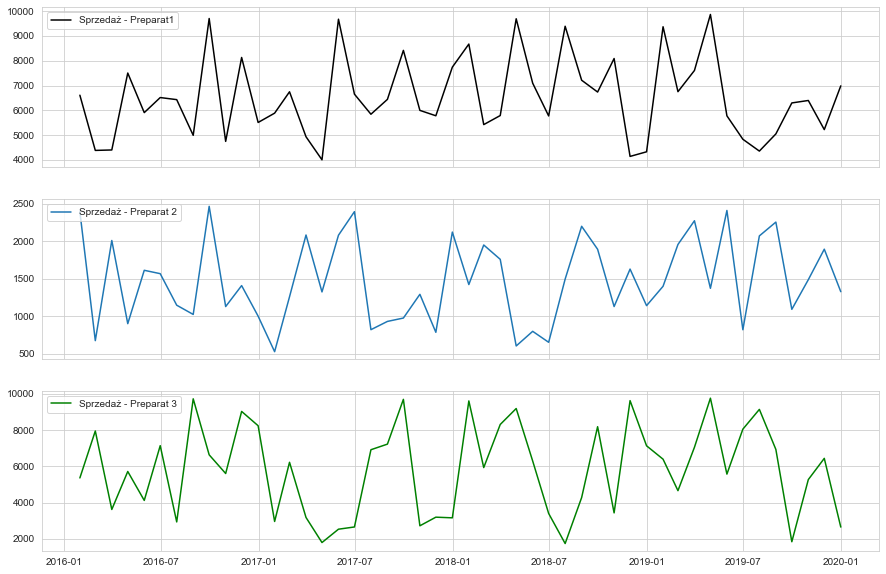

In [840]:
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False )
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].plot(df1.Sprzedaż, 'k', label='Sprzedaż - Preparat1')
    axes[0].legend(loc='upper left');

    axes[1].plot(df2.Sprzedaż, label='Sprzedaż - Preparat 2')
    axes[1].legend(loc='upper left');

    axes[2].plot(df3.Sprzedaż, 'g', label='Sprzedaż - Preparat 3')
    axes[2].legend(loc='upper left');


<b>Badanie własności rozkładu zmiennej prognozowanej <b>

In [841]:
def normal_plot(data):
    
    plt.figure(figsize=(10,4))
    color = sns.color_palette()
    sns.set_style('darkgrid')
    sns.distplot(data, fit=norm);

# Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
    plt.ylabel('Frequency')
    plt.title('Sprzedaż  - rozkład')

#Get also the QQ-plot
    fig = plt.figure(figsize=(10,4))
    res = scs.probplot(df3['Sprzedaż'], plot=plt)
    plt.show()


 mu = 6537.71 and sigma = 1625.53



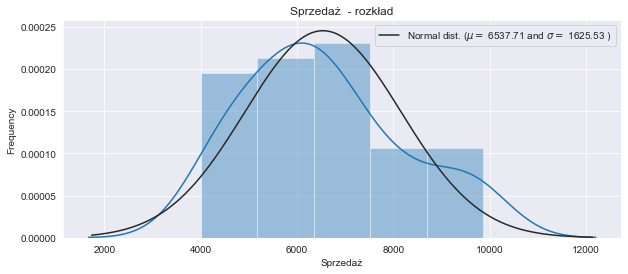

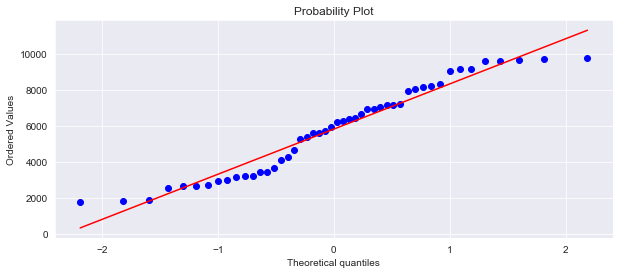

In [842]:
normal_plot(df1.Sprzedaż)


 mu = 1476.92 and sigma = 556.03



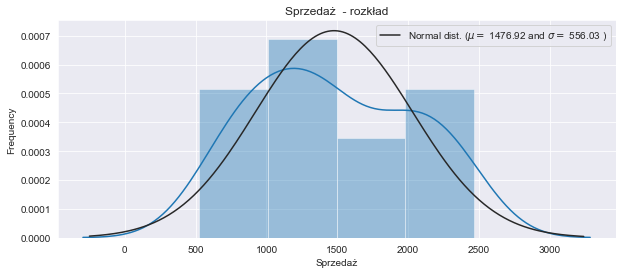

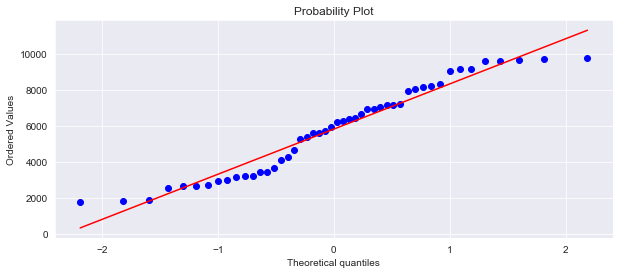

In [843]:
normal_plot(df2.Sprzedaż)


 mu = 5819.38 and sigma = 2479.14



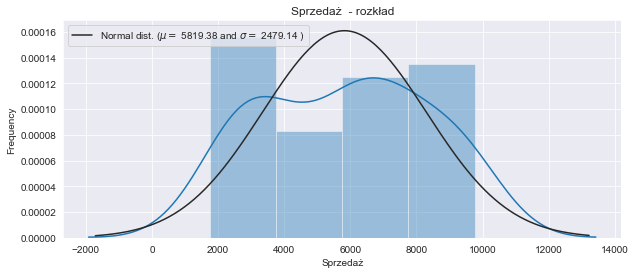

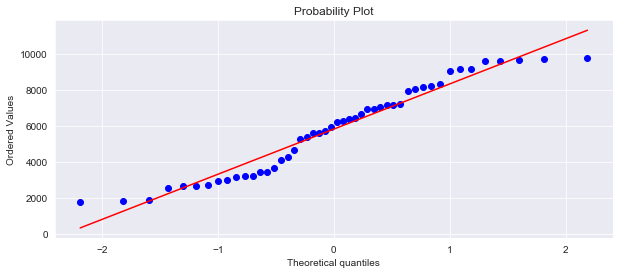

In [844]:
normal_plot(df3.Sprzedaż)

Na podstawie wykresów możemy przypuścić, że szeregi czasowe mają rozkład zbliżony do rozkładu normalnego

<b> Testowanie zgodności rozkładu z rozkładem normalnym <b>

In [845]:
def check_normal_distribution(data):
    print(f'skew = {skew(data)}')
    jarque_bera_test = scs.jarque_bera(data)
    print('statistic={:.2f}, pvalue={:.2f}'.format(jarque_bera_test[0],jarque_bera_test[1]))
    k2, p = stats.normaltest(data)
    print('statistic={:.2f}, pvalue={}'.format(k2,p))


In [846]:
check_normal_distribution(df1.Sprzedaż)

skew = 0.5082327382663937
statistic=2.79, pvalue=0.25
statistic=3.09, pvalue=0.21333141018308724


In [847]:
check_normal_distribution(df2.Sprzedaż)

skew = 0.16241120441280027
statistic=2.88, pvalue=0.24
statistic=9.56, pvalue=0.008406998609099423


In [848]:
check_normal_distribution(df3.Sprzedaż)

skew = -0.001334045527174956
statistic=3.03, pvalue=0.22
statistic=12.53, pvalue=0.0019050399027475565


Szereg czasowy preparatu przy poziomie istotności 5% ma rozkład zgodny z rozkładem normalnym. Z kolei wartości sprzedaży dla preparatu 2 i 3 wg test jarque bera rozkładają się w sposób zbliżony do rozkładu normalnego, natomiast drugi mocniejszy test odrzuca tę hipotezę. Wobec czego postanowiono dokonać transformacji logarytmicznej w celu zmniejszenia odległości między obserwacjami i przybliżenia do rozkładu normalnego. 

In [849]:
check_normal_distribution(np.log(df2.Sprzedaż))

skew = -0.40745627434626724
statistic=2.51, pvalue=0.28
statistic=3.38, pvalue=0.18463773436221115


In [850]:
check_normal_distribution(np.log(df3.Sprzedaż))

skew = -0.5810896391213539
statistic=3.97, pvalue=0.14
statistic=5.12, pvalue=0.07747227983217529


Po przekształceniu logarytmicznym szeregi czasowe przy poziomie istotności 5% charakteryzują się rozkładem normalnym

In [851]:
df2.Sprzedaż = np.log(df2.Sprzedaż)
df3.Sprzedaż = np.log(df3.Sprzedaż)

<b>Dekompozycja szeregu czasowego<b>

In [609]:
def seasonal_dec(data):
    sd = seasonal_decompose(data,freq=12)
    trend = sd.trend
    seasonal = sd.seasonal
    observed = sd.observed
    res = sd.resid

    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False )
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].plot(observed, 'k', label='Original')
    axes[0].legend(loc='upper left');

    axes[1].plot(trend, label='Trend')
    axes[1].legend(loc='upper left');

    axes[2].plot(seasonal, 'g', label='Seasonality')
    axes[2].legend(loc='upper left');

    axes[3].plot(res, 'r', label='Residuals')
    axes[3].legend(loc='upper left')
    plt.tight_layout()
    

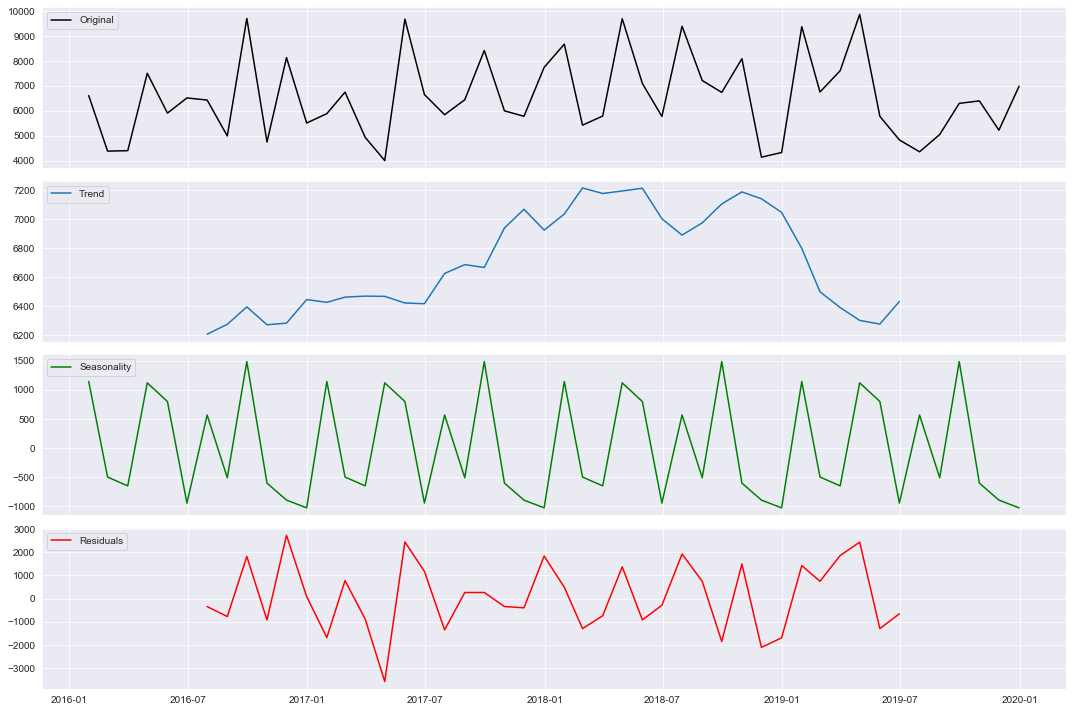

In [610]:
seasonal_dec(df1.Sprzedaż)

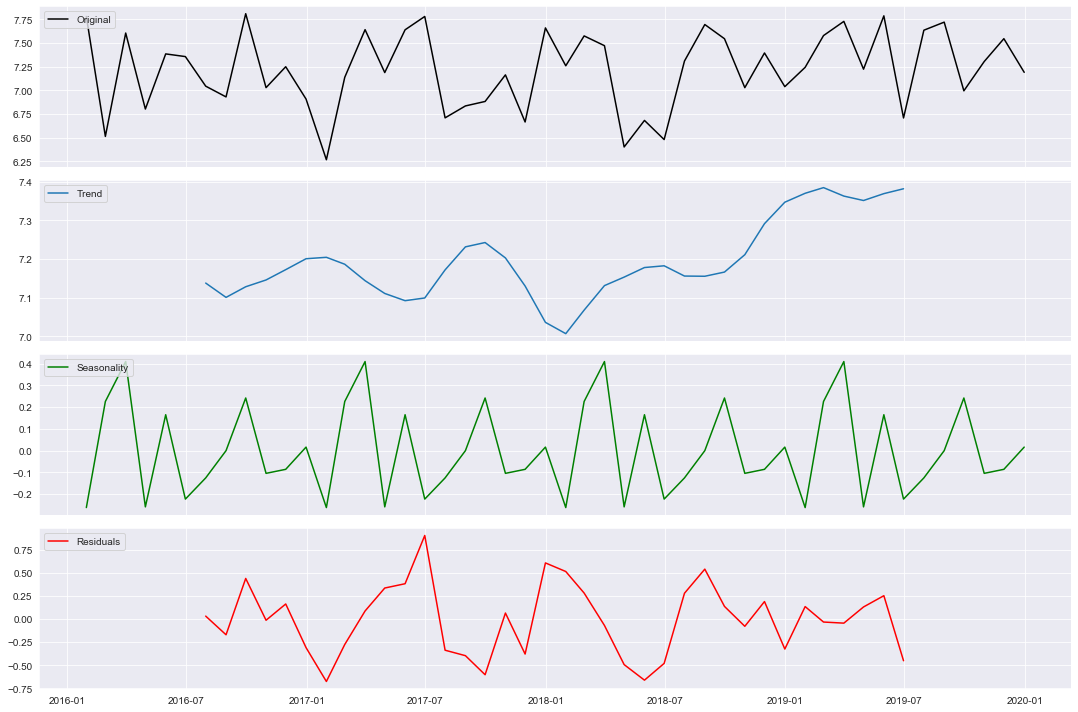

In [611]:
seasonal_dec(df2.Sprzedaż)

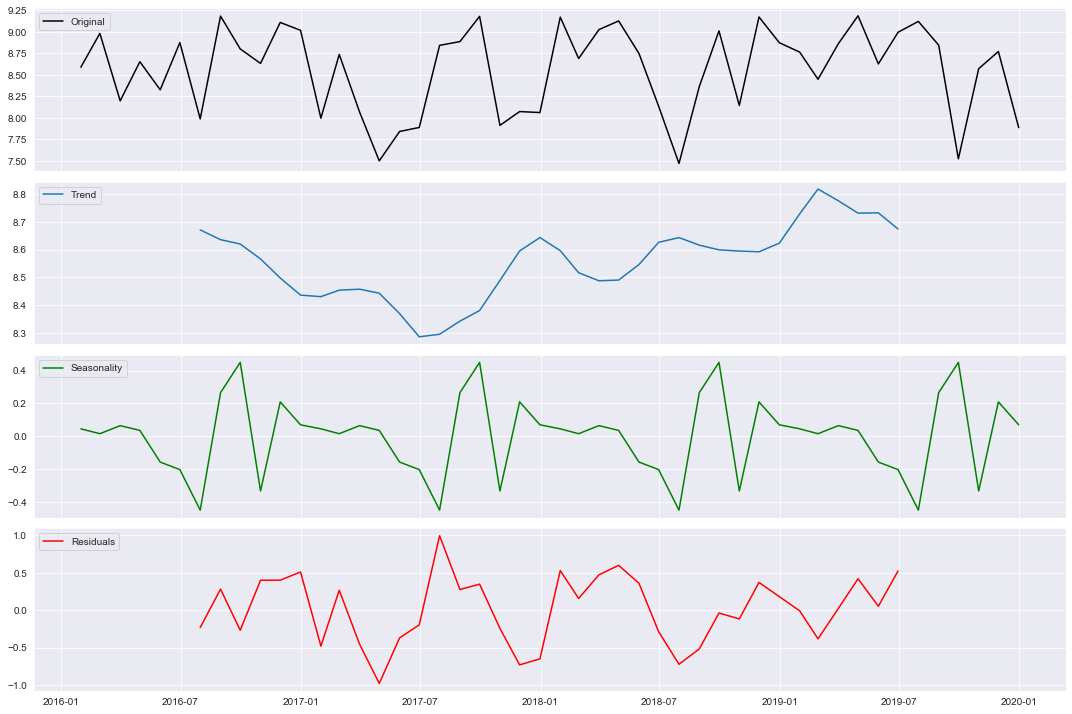

In [612]:
seasonal_dec(df3.Sprzedaż)

Szeregi czasowe odnaczają się podobną charakterystyką. Na podstawie wykresów wyodrębnionych składowych szergów czasowych, możemy wnioskać, co najwyżej o występowaniu słabej sezonowości oraz braku znaczącego trendu w ramach analizowanego okresu referencyjnego.

<b> Badanie występowania autokorelacji<b>

In [613]:
def lag_test(data):
    data['constant']=1 
    model = sm.OLS(data.Sprzedaż.values,data['constant'])
    results = model.fit()
    ljungbox = sm.stats.acorr_ljungbox(results.resid, lags=[1,2,3,4,5,6,7,8,9,10])
    ljunbox_test = pd.DataFrame({'Wartość testu':ljungbox[0],
             'p-value': ljungbox[1]}, index=range(1,11))
    ljunbox_test.index.name = 'Lags'
    return ljunbox_test

In [614]:
lag_test(df1)

,Wartość testu,p-value
Lags,,
1,0.494929,0.481737
2,1.789782,0.408652
3,4.543897,0.208408
4,5.133533,0.273869
5,7.008174,0.220033
6,7.459672,0.280418
7,7.510520,0.377724
8,9.302495,0.317424
9,9.312976,0.408900


In [615]:
lag_test(df2)

,Wartość testu,p-value
Lags,,
1,0.035578,0.850390
2,0.069497,0.965848
3,0.667882,0.880731
4,5.058853,0.281312
5,6.390128,0.270086
6,10.179859,0.117279
7,10.208185,0.177080
8,13.326598,0.101096
9,15.730096,0.072736


In [616]:
lag_test(df3)

,Wartość testu,p-value
Lags,,
1,1.347887,0.245648
2,1.366260,0.505034
3,1.676818,0.642100
4,2.679535,0.612800
5,7.492341,0.186522
6,7.573611,0.271034
7,9.031166,0.250426
8,9.390992,0.310393
9,9.720202,0.373608


Na podstawie testu ljunga-boxa stwierdzamy, że  przy poziomie istotności 5% nie występuje autokorelacja w analizowanym okresie w szeregach czasowych.

<b>Badanie stacjonarności szeregu czasowego<b>

In [617]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [618]:
adf_test(df1.Sprzedaż)

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.757580
p-value                  0.003372
# lags used              2.000000
# observations          45.000000
critical value (1%)     -3.584829
critical value (5%)     -2.928299
critical value (10%)    -2.602344
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [619]:
adf_test(df2.Sprzedaż)

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.028104e+00
p-value                 6.287502e-10
# lags used             0.000000e+00
# observations          4.700000e+01
critical value (1%)    -3.577848e+00
critical value (5%)    -2.925338e+00
critical value (10%)   -2.600774e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [620]:
adf_test(df3.Sprzedaż)

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.540383
p-value                  0.000002
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Test ADF wykazał, że szereg czasowy jest stacjonarny

# Modelowanie predykcyjne

W celu prównania skuteczności prognozy wykorzystanych metod dokonano podziału danych na zbiór treningowy i testowy. Porównania dokonano w oparciu o błąd RMSE

In [621]:
train = df1.Sprzedaż[:42]
test = df1.Sprzedaż[42:]


# Model ARIMA

Na podstawie wartości kryterium informacyjnych AIC dokonujemy wyboru rzędu procesów AR (p) i MA (q), minimalizując utracone informacje, spowodowane brakiem dopoasowania i złożonością modelu. Do badania stacjonarności zastosowano test adf

In [622]:
stepwise_fit = auto_arima(train, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',
                          information_criterion='aic',
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 50, random=True, n_iter=50, test='adf')        

stepwise_fit.summary()

Fit ARIMA: order=(3, 0, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 2); AIC=750.990, BIC=763.154, Fit time=0.474 seconds
Fit ARIMA: order=(2, 0, 2); AIC=753.453, BIC=763.879, Fit time=0.545 seconds
Fit ARIMA: order=(2, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=747.961, BIC=756.650, Fit time=0.139 seconds
Fit ARIMA: order=(4, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=746.574, BIC=750.050, Fit time=0.002 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 0); AIC=746.331, BIC=755.020, Fit time=0.125 seconds
Fit ARIMA: order=(4, 0, 1); AIC=752.825, BIC=764.988, Fit time=1.076 seconds
Fit ARIMA: order=(0, 0, 2); AIC=747.244, BIC=754.195, Fit time=0.056 seconds
Fit ARIMA: order=(1, 0, 1); AIC=748.192, BIC=755.143, Fit t

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:                     ARMA(2, 0)   Log Likelihood                -369.034
Method:                       css-mle   S.D. of innovations           1580.158
Date:                Fri, 27 Nov 2020   AIC                            746.068
Time:                        21:33:20   BIC                            753.019
Sample:                             0   HQIC                           748.616
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6684.2697    164.169     40.716      0.000    6362.504    7006.035
ar.L1.y       -0.2284      0.150     -1.523      0.136      -0.522       0.066
ar.L2.y       -0.2783      0.151     -1.842      0.073      -0.574       0.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4103           -1.8505j            1.8954           -0.2847
AR.2           -0.4103           +1.8505j            1.8954            0.2847
-----------------------------------------------------------------------------
"""

<b>Budowa modelu SARIMA(2,0,0)<b>

In [623]:
model = ARIMA(train,order=(2,0,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Sprzedaż   No. Observations:                   42
Model:                     ARMA(2, 0)   Log Likelihood                -369.034
Method:                       css-mle   S.D. of innovations           1580.158
Date:                Fri, 27 Nov 2020   AIC                            746.068
Time:                        21:33:26   BIC                            753.019
Sample:                    01-31-2016   HQIC                           748.616
                         - 06-30-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6684.2697    164.169     40.716      0.000    6362.504    7006.035
ar.L1.Sprzedaż    -0.2284      0.150     -1.523      0.136      -0.522       0.066
ar.L2.Sprzedaż    -0.2783      0.151     -1.842      0.073      -0.574       0.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4103           -1.8505j            1.8954           -0.2847
AR.2           -0.4103           +1.8505j            1.8954            0.2847
-----------------------------------------------------------------------------
"""

Określenie przdziału prognozy

In [624]:
start=len(train)
end=len(test)+len(train)
predictions = results.predict(start=start, end=end).rename('ARMA(2,0) Predictions')

<b> Wizualizacja prognozy i rzeczywistej sprzedaży <b>

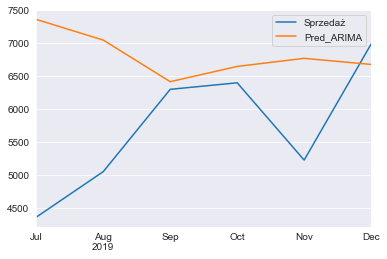

In [625]:
test= pd.DataFrame(test)
test['Pred_ARIMA']=predictions
test.plot(legend=True)

<b> Wyznaczenie błędu RMSE<b>

In [626]:
pred_arima = rmse(test['Sprzedaż'],test['Pred_ARIMA'])
RMSE = pd.Series()
RMSE['rmse_ARIMA']= pred_arima

# Model SARIMA

In [627]:
stepwise_fit = auto_arima(train, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 50, random=True, n_iter=50, test='adf')        

stepwise_fit.summary()

Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=749.449, BIC=763.351, Fit time=0.431 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=750.026, BIC=756.977, Fit time=0.065 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(2, 0, 1, 12); AIC=752.799, BIC=770.176, Fit time=0.719 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=752.880, BIC=770.257, Fit time=0.548 seconds
Fit ARIMA: order=(3, 0, 4) seasonal_order=(1, 0, 1, 12); AIC=756.095, BIC=775.209, Fit time=0.524 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=na

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   42
Model:             SARIMAX(3, 0, 0)x(1, 0, 1, 12)   Log Likelihood                -367.071
Date:                            Fri, 27 Nov 2020   AIC                            748.143
Time:                                    21:33:46   BIC                            760.306
Sample:                                         0   HQIC                           752.601
                                             - 42                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8761.0534   1.03e+04      0.853      0.393   -1.14e+04    2.89e+04
ar.L1         -0.1925      0.168     -1.144      0.253      -0.522       0.137
ar.L2         -0.2315      0.229     -1.011      0.312      -0.680       0.217
ar.L3          0.2366      0.205      1.156      0.247      -0.164       0.638
ar.S.L12      -0.1098      1.179     -0.093      0.926      -2.421       2.201
ma.S.L12       0.4256      1.097      0.388      0.698      -1.724       2.576
sigma2      2.224e+06     42.097   5.28e+04      0.000    2.22e+06    2.22e+06
===================================================================================
Ljung-Box (Q):                       24.41   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.98   Prob(JB):                         0.70
Heteroskedasticity (H):               0.91   Skew:                            -0.04
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.36e+20. Standard errors may be unstable.
"""

In [628]:
model1 = SARIMAX(train, order=(3,0,0) , seasonal_order=(1,0,1,12))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Sprzedaż   No. Observations:                   42
Model:             SARIMAX(3, 0, 0)x(1, 0, 1, 12)   Log Likelihood                -374.552
Date:                            Fri, 27 Nov 2020   AIC                            761.103
Time:                                    21:33:52   BIC                            771.529
Sample:                                01-31-2016   HQIC                           764.925
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2009      0.172      1.171      0.242      -0.135       0.537
ar.L2          0.1680      0.135      1.242      0.214      -0.097       0.433
ar.L3          0.6081      0.135      4.512      0.000       0.344       0.872
ar.S.L12      -0.4525      2.060     -0.220      0.826      -4.489       3.584
ma.S.L12       0.6762      2.087      0.324      0.746      -3.415       4.767
sigma2      3.037e+06   3.07e-06    9.9e+11      0.000    3.04e+06    3.04e+06
===================================================================================
Ljung-Box (Q):                       21.07   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.99   Prob(JB):                         0.48
Heteroskedasticity (H):               0.85   Skew:                             0.19
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+28. Standard errors may be unstable.
"""

In [629]:
predictions1 = results1.predict(start,end).rename('SARIMA Prediction')

In [630]:
test['Pred_SARIMA'] = predictions1

<b>Wizualizacja prognozy i rzeczywistej sprzedaży<b>

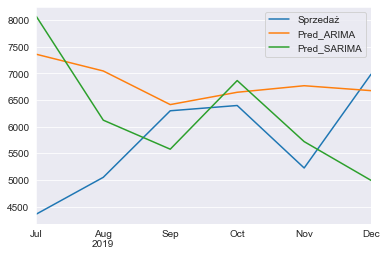

In [631]:
test.plot(legend=True)

In [632]:
pred_sarima = rmse(test['Sprzedaż'],test['Pred_SARIMA'])
RMSE['rmse_SARIMA'] =pred_sarima

# Model Holta Wintersa


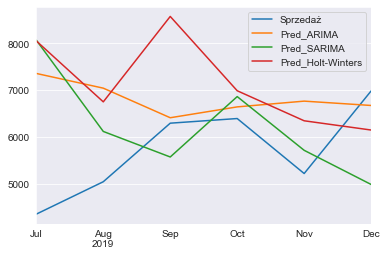

In [633]:
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
predictions2 = model2.forecast(6)
test['Pred_Holt-Winters'] = predictions2
test.plot(legend=True)

In [634]:
pred_holt_winters = rmse(test['Sprzedaż'],test['Pred_Holt-Winters'])
RMSE['rmse_Holt_Winters'] =pred_holt_winters

# Model Prophet
Modele te umożliwiają na ujęcie wzorców szeregu czasowego, w którym mamy do czynienia z występowaniem nieliniowego trendu i sezonowości. Ponadto pozwalają na modelowanie w oparciu o dodatkowe zmienne endogeniczne.

In [635]:
df_prophet = df1.copy()

In [636]:
df_prophet.reset_index(inplace=True)
df_prophet = df_prophet[['index','Sprzedaż']]

In [637]:
df_prophet.columns = ['ds','y']
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
ds    48 non-null datetime64[ns]
y     48 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 896.0 bytes


In [638]:
train_prophet = df_prophet.iloc[:42]
test_prophet = df_prophet.iloc[42:]

In [639]:
p = Prophet(weekly_seasonality=False,
        daily_seasonality=False,seasonality_prior_scale=1.0,
           n_changepoints=10)
p.fit(train_prophet)
future = p.make_future_dataframe(periods=6, freq='MS')
predictions_p = p.predict(future)

In [640]:
prop1 = predictions_p[['ds','yhat']][-6:]
prop1.columns = ['DATE', 'Pred_prophet']
prop1 = pd.DataFrame(prop1)
index=pd.date_range('2019-07','2020-01',freq='M')
prop1.set_index(index,inplace=True)
prop1.drop('DATE', axis=1, inplace=True)
test['Pred_Prophet'] = prop1['Pred_prophet']
pred_prophet = rmse(test['Sprzedaż'],test['Pred_Prophet'])
RMSE['rmse_Prophet'] =pred_prophet

<b> Wizualizacja prognozy<b>

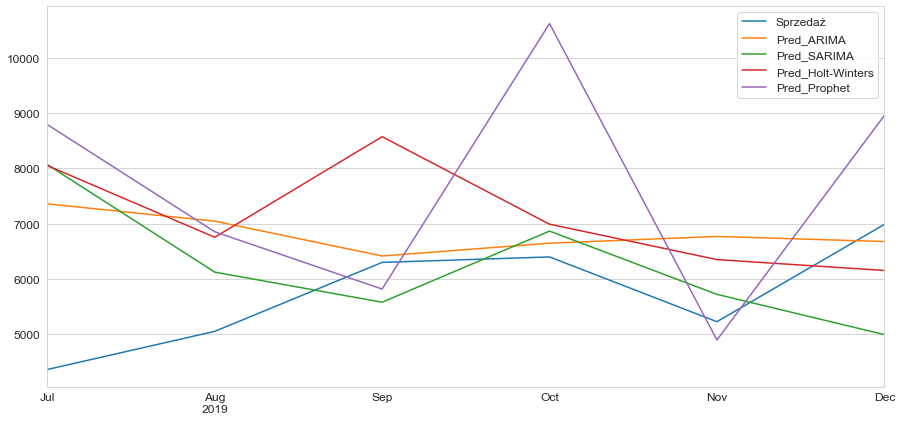

In [641]:
pd.plotting.register_matplotlib_converters()
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))
test.plot(ax=ax, fontsize=12)
plt.legend(loc='best', prop={'size': 12})

<b> Tabela z wartościami błędu RMSE dla preparatu 1 posortowanego w sposób rosnący<b>

In [642]:
pd.DataFrame(RMSE.sort_values(ascending=True), columns=['RMSE Preparat 1'])

,RMSE Preparat 1
rmse_ARIMA,1609.678972
rmse_SARIMA,1820.621937
rmse_Holt_Winters,2002.084104
rmse_Prophet,2739.669154


# Budowa modeli predykcyjnych dla preparatu 2

Analizę dla preparatu 2 przeprowadzono w sposób analogiczny jak w przypadku 1 preparatu

In [747]:
train = df2.Sprzedaż[:42]
test = df2.Sprzedaż[42:]


In [748]:
stepwise_fit = auto_arima(train, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',
                          information_criterion='aic',
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 50, random=True, n_iter=50, test='adf')        

stepwise_fit.summary()

Fit ARIMA: order=(3, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 2); AIC=53.070, BIC=65.234, Fit time=0.302 seconds
Fit ARIMA: order=(4, 0, 1); AIC=51.307, BIC=63.470, Fit time=0.126 seconds
Fit ARIMA: order=(0, 0, 1); AIC=52.607, BIC=57.820, Fit time=0.020 seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 1); AIC=51.799, BIC=62.225, Fit time=0.144 seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=52.606, BIC=57.819, Fit time=0.020 seconds
Fit ARIMA: order=(1, 0, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=50.618, BIC=54.094, Fit time=0.004 seconds
Fit ARIMA: order=(0, 0, 4); AIC=47.479, BIC=57.905, Fit time=0.163 seconds
Fit ARIMA: order=(2, 0, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:                     ARMA(0, 4)   Log Likelihood                 -17.739
Method:                       css-mle   S.D. of innovations              0.354
Date:                Fri, 27 Nov 2020   AIC                             47.479
Time:                        22:08:24   BIC                             57.905
Sample:                             0   HQIC                            51.301
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1718      0.012    578.413      0.000       7.148       7.196
ma.L1.y       -0.2396      0.150     -1.592      0.120      -0.535       0.055
ma.L2.y        0.0762      0.148      0.515      0.609      -0.214       0.366
ma.L3.y       -0.3331      0.134     -2.489      0.017      -0.595      -0.071
ma.L4.y       -0.5035      0.145     -3.473      0.001      -0.788      -0.219
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.0682           -1.1391j            1.1411           -0.2595
MA.3           -0.0682           +1.1391j            1.1411            0.2595
MA.4           -1.5252           -0.0000j            1.5252           -0.5000
-----------------------------------------------------------------------------
"""

In [749]:
model = ARIMA(train,order=(0,0,4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Sprzedaż   No. Observations:                   42
Model:                     ARMA(0, 4)   Log Likelihood                 -17.739
Method:                       css-mle   S.D. of innovations              0.354
Date:                Fri, 27 Nov 2020   AIC                             47.479
Time:                        22:08:24   BIC                             57.905
Sample:                    01-31-2016   HQIC                            51.301
                         - 06-30-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.1718      0.012    578.413      0.000       7.148       7.196
ma.L1.Sprzedaż    -0.2396      0.150     -1.592      0.120      -0.535       0.055
ma.L2.Sprzedaż     0.0762      0.148      0.515      0.609      -0.214       0.366
ma.L3.Sprzedaż    -0.3331      0.134     -2.489      0.017      -0.595      -0.071
ma.L4.Sprzedaż    -0.5035      0.145     -3.473      0.001      -0.788      -0.219
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.0682           -1.1391j            1.1411           -0.2595
MA.3           -0.0682           +1.1391j            1.1411            0.2595
MA.4           -1.5252           -0.0000j            1.5252           -0.5000
-----------------------------------------------------------------------------
"""

In [750]:
start=len(train)
end=len(test)+len(train)
predictions = results.predict(start=start, end=end).rename('ARMA(0,4) Predictions')

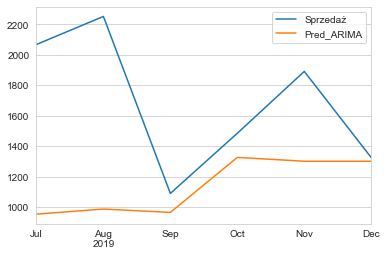

In [751]:
test= pd.DataFrame(np.expm1(test))
test['Pred_ARIMA']=np.expm1(predictions)
test.plot(legend=True)

In [752]:
pred_arima = rmse(test['Sprzedaż'],test['Pred_ARIMA'])
RMSE = pd.Series()
RMSE['rmse_ARIMA']= pred_arima

In [753]:
stepwise_fit = auto_arima(train, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 50, random=True, n_iter=50, test='adf')        

stepwise_fit.summary()

Fit ARIMA: order=(3, 0, 1) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 0, 3) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 12); AIC=59.180, BIC=71.344, Fit time=0.605 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=55.943, BIC=69.845, Fit time=0.507 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=55.216, BIC=63.905, Fit time=0.209 seconds
Fit ARIMA: order=(0, 0, 4) seasonal_order=(1, 0, 1, 12); AIC=50.312, BIC=64.214, Fit time=0.948 seconds
Fit ARIMA: order=(4, 0, 1) seasonal_order=(2, 0, 1, 12); AIC=56.751, BIC=74.128, Fit time=1.034 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   42
Model:             SARIMAX(0, 0, 4)x(1, 0, 1, 12)   Log Likelihood                 -17.156
Date:                            Fri, 27 Nov 2020   AIC                             50.312
Time:                                    22:08:43   BIC                             64.214
Sample:                                         0   HQIC                            55.408
                                             - 42                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.0924     13.547      0.524      0.601     -19.459      33.644
ma.L1         -0.2417      1.268     -0.191      0.849      -2.727       2.244
ma.L2          0.0581      0.982      0.059      0.953      -1.867       1.983
ma.L3         -0.3054      1.022     -0.299      0.765      -2.308       1.697
ma.L4         -0.4852      0.673     -0.721      0.471      -1.803       0.833
ar.S.L12       0.0110      1.890      0.006      0.995      -3.692       3.714
ma.S.L12      -0.1946      1.818     -0.107      0.915      -3.758       3.368
sigma2         0.1209      0.154      0.783      0.434      -0.182       0.424
===================================================================================
Ljung-Box (Q):                       41.17   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.42   Prob(JB):                         0.81
Heteroskedasticity (H):               0.88   Skew:                             0.13
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [754]:
model1 = SARIMAX(train, order=(0,0,4) , seasonal_order=(1,0,1,12))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Sprzedaż   No. Observations:                   42
Model:             SARIMAX(0, 0, 4)x(1, 0, 1, 12)   Log Likelihood                 -52.372
Date:                            Fri, 27 Nov 2020   AIC                            118.744
Time:                                    22:08:44   BIC                            130.907
Sample:                                01-31-2016   HQIC                           123.202
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0389      0.182      5.705      0.000       0.682       1.396
ma.L2          1.3734      0.370      3.715      0.000       0.649       2.098
ma.L3          1.0471      0.551      1.900      0.057      -0.033       2.127
ma.L4          0.4278      0.314      1.364      0.173      -0.187       1.043
ar.S.L12       0.9982      0.026     39.086      0.000       0.948       1.048
ma.S.L12      -0.8204      1.221     -0.672      0.502      -3.213       1.572
sigma2         0.2813      0.350      0.803      0.422      -0.405       0.968
===================================================================================
Ljung-Box (Q):                       29.39   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.89   Prob(JB):                         0.58
Heteroskedasticity (H):               0.59   Skew:                            -0.13
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [755]:
predictions1 = results1.predict(start,end).rename('SARIMA Prediction')

In [756]:
test['Pred_SARIMA'] = np.expm1(predictions1)

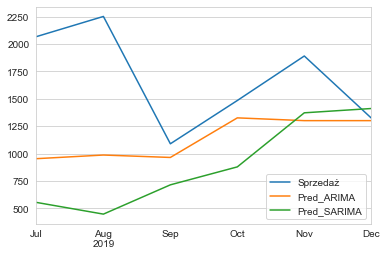

In [757]:
test.plot(legend=True)

In [758]:
pred_sarima = rmse(test['Sprzedaż'],test['Pred_SARIMA'])
RMSE['rmse_SARIMA'] =pred_sarima

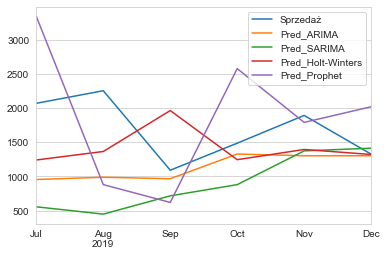

In [773]:
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
predictions2 = model2.forecast(6)
test['Pred_Holt-Winters'] = np.expm1(predictions2)
test.plot(legend=True)

In [762]:
pred_holt_winters = rmse(test['Sprzedaż'],test['Pred_Holt-Winters'])
RMSE['rmse_Holt_Winters'] =pred_holt_winters

In [763]:
df_prophet = df2.copy()

In [764]:
df_prophet.reset_index(inplace=True)
df_prophet = df_prophet[['index','Sprzedaż']]

In [765]:
df_prophet.columns = ['ds','y']
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
ds    48 non-null datetime64[ns]
y     48 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 896.0 bytes


In [766]:
train_prophet = df_prophet.iloc[:42]
test_prophet = df_prophet.iloc[42:]

In [767]:
p = Prophet(weekly_seasonality=False,
        daily_seasonality=False,)
p.fit(train_prophet)
future = p.make_future_dataframe(periods=6, freq='MS')
predictions_p = p.predict(future)

In [768]:
prop1 = predictions_p[['ds','yhat']][-6:]
prop1.columns = ['DATE', 'Pred_prophet']
prop1 = pd.DataFrame(prop1)
index=pd.date_range('2019-07','2020-01',freq='M')
prop1.set_index(index,inplace=True)
prop1.drop('DATE', axis=1, inplace=True)
test['Pred_Prophet'] = np.expm1(prop1['Pred_prophet'])
pred_prophet = rmse(test['Sprzedaż'],test['Pred_Prophet'])
RMSE['rmse_Prophet'] =pred_prophet

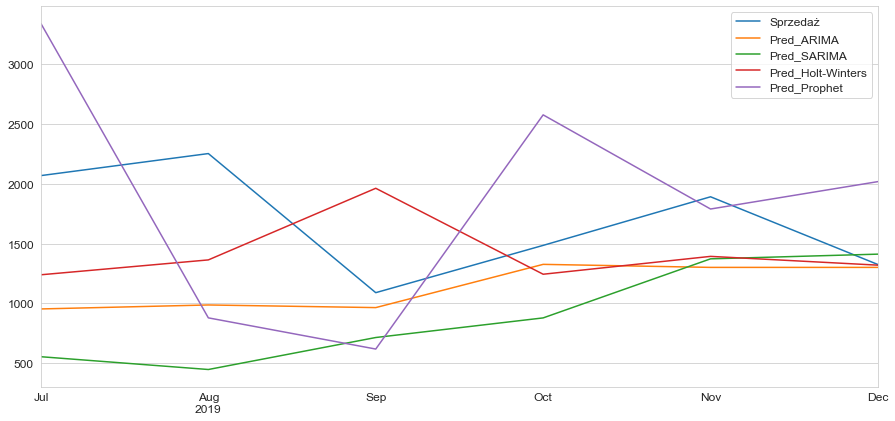

In [769]:
pd.plotting.register_matplotlib_converters()
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))
test.plot(ax=ax, fontsize=12)
plt.legend(loc='best', prop={'size': 12})

In [774]:
pd.DataFrame(RMSE.sort_values(ascending=True), columns=['RMSE Preparat 2'])

,RMSE Preparat 2
rmse_Holt_Winters,650.874119
rmse_ARIMA,733.642025
rmse_Prophet,948.410180
rmse_SARIMA,1026.859238


# Budowa modeli predykcyjnych dla preparatu 3

In [691]:
train = df3.Sprzedaż[:42]
test = df3.Sprzedaż[42:]


In [692]:
stepwise_fit = auto_arima(train, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',
                          information_criterion='aic',
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 50, random=True, n_iter=50, test='adf')        

stepwise_fit.summary()

Fit ARIMA: order=(3, 1, 2); AIC=70.920, BIC=82.915, Fit time=0.365 seconds
Fit ARIMA: order=(3, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 0); AIC=77.974, BIC=88.255, Fit time=0.106 seconds
Fit ARIMA: order=(1, 1, 3); AIC=70.217, BIC=80.498, Fit time=0.233 seconds
Fit ARIMA: order=(3, 1, 1); AIC=69.688, BIC=79.969, Fit time=0.179 seconds
Fit ARIMA: order=(4, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 3); AIC=68.505, BIC=77.073, Fit time=0.125 seconds
Fit ARIMA: order=(0, 1, 2); AIC=67.492, BIC=74.347, Fit time=0.050 seconds
Fit ARIMA: order=(2, 1, 3); AIC=73.674, BIC=85.669, Fit time=0.242 seconds
Fit ARIMA: order=(1, 1, 1); AIC=67.150, BIC=74.004, Fit time=0.126 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=70.308, BIC=80.589, Fit time=0.20

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   41
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -30.537
Method:                       css-mle   S.D. of innovations              0.487
Date:                Fri, 27 Nov 2020   AIC                             67.073
Time:                        21:36:57   BIC                             72.214
Sample:                             1   HQIC                            68.945
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.006      0.812      0.422      -0.007       0.017
ma.L1.D.y     -1.0000      0.093    -10.763      0.000      -1.182      -0.818
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [693]:
model = ARIMA(train,order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.Sprzedaż   No. Observations:                   41
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -30.537
Method:                       css-mle   S.D. of innovations              0.487
Date:                Fri, 27 Nov 2020   AIC                             67.073
Time:                        21:37:00   BIC                             72.214
Sample:                    02-29-2016   HQIC                            68.945
                         - 06-30-2019                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0050      0.006      0.812      0.422      -0.007       0.017
ma.L1.D.Sprzedaż    -1.0000      0.093    -10.763      0.000      -1.182      -0.818
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [694]:
start=len(train)
end=len(test)+len(train)
predictions = results.predict(start=start, end=end, typ='levels').rename('ARMA(0,4) Predictions')

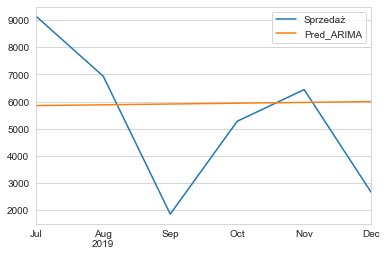

In [695]:
test= pd.DataFrame(np.expm1(test))
test['Pred_ARIMA']=np.expm1(predictions)
test.plot(legend=True)

In [696]:
pred_arima = rmse(test['Sprzedaż'],test['Pred_ARIMA'])
RMSE = pd.Series()
RMSE['rmse_ARIMA']= pred_arima

In [697]:
stepwise_fit = auto_arima(train, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 50, random=True, n_iter=50, test='adf')        

stepwise_fit.summary()

Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 0, 1, 12); AIC=77.536, BIC=94.672, Fit time=0.881 seconds
Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=82.247, BIC=97.670, Fit time=0.861 seconds
Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=80.715, BIC=92.710, Fit time=0.659 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 4) seasonal_order=(1, 0, 1, 12); AIC=73.786, BIC=90.922, Fit time=0.528 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   42
Model:             SARIMAX(0, 1, 2)x(1, 0, 1, 12)   Log Likelihood                 -29.435
Date:                            Fri, 27 Nov 2020   AIC                             70.870
Time:                                    21:37:25   BIC                             81.151
Sample:                                         0   HQIC                            74.614
                                             - 42                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0060      0.023      0.265      0.791      -0.039       0.051
ma.L1         -0.8327     10.287     -0.081      0.935     -20.994      19.329
ma.L2         -0.1658      1.780     -0.093      0.926      -3.655       3.324
ar.S.L12       0.0124      2.096      0.006      0.995      -4.096       4.121
ma.S.L12      -0.1598      2.214     -0.072      0.942      -4.500       4.180
sigma2         0.2238      2.310      0.097      0.923      -4.305       4.752
===================================================================================
Ljung-Box (Q):                       26.12   Jarque-Bera (JB):                 2.79
Prob(Q):                              0.96   Prob(JB):                         0.25
Heteroskedasticity (H):               1.04   Skew:                            -0.41
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [698]:
model1 = SARIMAX(train, order=(0,1,2) , seasonal_order=(1,0,1,12))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Sprzedaż   No. Observations:                   42
Model:             SARIMAX(0, 1, 2)x(1, 0, 1, 12)   Log Likelihood                 -29.761
Date:                            Fri, 27 Nov 2020   AIC                             69.522
Time:                                    21:37:38   BIC                             78.090
Sample:                                01-31-2016   HQIC                            72.642
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8311     20.912     -0.040      0.968     -41.817      40.155
ma.L2         -0.1683      3.599     -0.047      0.963      -7.222       6.885
ar.S.L12       0.6856      2.150      0.319      0.750      -3.528       4.900
ma.S.L12      -0.8526      2.783     -0.306      0.759      -6.307       4.602
sigma2         0.2204      4.659      0.047      0.962      -8.910       9.351
===================================================================================
Ljung-Box (Q):                       24.65   Jarque-Bera (JB):                 2.67
Prob(Q):                              0.97   Prob(JB):                         0.26
Heteroskedasticity (H):               1.10   Skew:                            -0.42
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [699]:
predictions1 = results1.predict(start,end).rename('SARIMA Prediction')

In [700]:
test['Pred_SARIMA'] = np.expm1(predictions1)

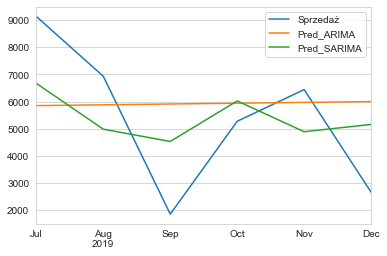

In [701]:
test.plot(legend=True)

In [702]:
pred_sarima = rmse(test['Sprzedaż'],test['Pred_SARIMA'])
RMSE['rmse_SARIMA'] =pred_sarima

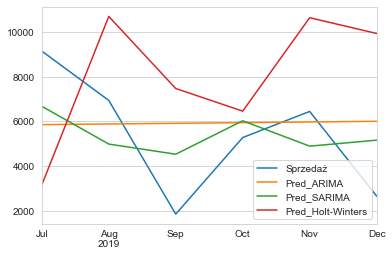

In [703]:
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
predictions2 = model2.forecast(6)
test['Pred_Holt-Winters'] = np.expm1(predictions2)
test.plot(legend=True)

In [704]:
pred_holt_winters = rmse(test['Sprzedaż'],test['Pred_Holt-Winters'])
RMSE['rmse_Holt_Winters'] =pred_holt_winters

In [705]:
df_prophet = df3.copy()

In [706]:
df_prophet.reset_index(inplace=True)
df_prophet = df_prophet[['index','Sprzedaż']]

In [707]:
df_prophet.columns = ['ds','y']
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
ds    48 non-null datetime64[ns]
y     48 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 896.0 bytes


In [708]:
train_prophet = df_prophet.iloc[:42]
test_prophet = df_prophet.iloc[42:]

In [709]:
p = Prophet(weekly_seasonality=False,
        daily_seasonality=False,)
p.fit(train_prophet)
future = p.make_future_dataframe(periods=6, freq='MS')
predictions_p = p.predict(future)

In [710]:
prop1 = predictions_p[['ds','yhat']][-6:]
prop1.columns = ['DATE', 'Pred_prophet']
prop1 = pd.DataFrame(prop1)
index=pd.date_range('2019-07','2020-01',freq='M')
prop1.set_index(index,inplace=True)
prop1.drop('DATE', axis=1, inplace=True)
test['Pred_Prophet'] = np.expm1(prop1['Pred_prophet'])
pred_prophet = rmse(test['Sprzedaż'],test['Pred_Prophet'])
RMSE['rmse_Prophet'] =pred_prophet

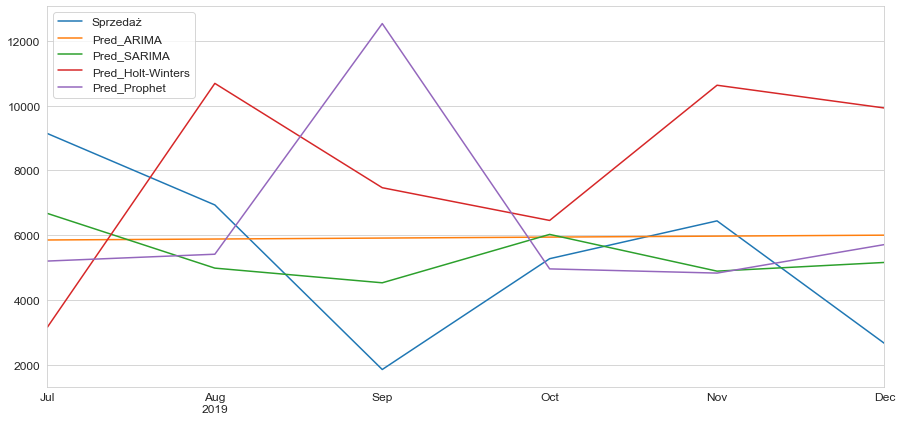

In [711]:
pd.plotting.register_matplotlib_converters()
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))
test.plot(ax=ax, fontsize=12)
plt.legend(loc='best', prop={'size': 12})

In [712]:
pd.DataFrame(RMSE.sort_values(ascending=True), columns=['RMSE Preparat3'])

,RMSE Preparat3
rmse_SARIMA,2093.865088
rmse_ARIMA,2590.321798
rmse_Prophet,4900.402865
rmse_Holt_Winters,5053.984537


# Podsumowanie

Dla preparatu 1 najmniejszy błąd RMSE uzyskał model SARIMA, dla preparatu 2 model Holta-Wintera oraz dla parametru 3 również model SARIMA. W dalszej kolejności dokonano właściwej prognozy wykorzystując wyżej wymienione modele dla odpowiednich preparatów.

# Prognoza preparatu 1 modelem SARIMA

In [713]:
stepwise_fit = auto_arima(df1.Sprzedaż, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 50, random=True, n_iter=50, test='adf')        

stepwise_fit.summary()

Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=852.089, BIC=868.740, Fit time=0.432 seconds
Fit ARIMA: order=(4, 1, 1) seasonal_order=(2, 0, 1, 12); AIC=850.541, BIC=869.043, Fit time=1.128 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 2) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 0, 1, 12); AIC=849.056, BIC=869.407, Fit time=1.604 seconds
Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=848.736, BIC=867.238, Fit time=0.682 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=862.932, BIC=872.182, Fit time=0.291 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=na

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -417.116
Date:                            Fri, 27 Nov 2020   AIC                            844.231
Time:                                    21:45:53   BIC                            853.482
Sample:                                         0   HQIC                           847.712
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.1485     63.280      0.397      0.691     -98.879     149.176
ma.L1         -0.9747      0.249     -3.919      0.000      -1.462      -0.487
ar.S.L12      -0.7012      0.199     -3.527      0.000      -1.091      -0.312
ma.S.L12       0.9993      0.311      3.209      0.001       0.389       1.610
sigma2      2.441e+06   9.82e-07   2.48e+12      0.000    2.44e+06    2.44e+06
===================================================================================
Ljung-Box (Q):                       31.31   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.84   Prob(JB):                         0.64
Heteroskedasticity (H):               0.76   Skew:                             0.31
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

In [817]:
model1 = SARIMAX(df1.Sprzedaż, order=(0,1,1) , seasonal_order=(1,0,1,12))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Sprzedaż   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -417.379
Date:                            Fri, 27 Nov 2020   AIC                            842.757
Time:                                    23:22:16   BIC                            850.158
Sample:                                01-31-2016   HQIC                           845.542
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9271      0.087    -10.667      0.000      -1.097      -0.757
ar.S.L12      -0.7094      0.199     -3.557      0.000      -1.100      -0.319
ma.S.L12       0.9720      0.256      3.804      0.000       0.471       1.473
sigma2      2.591e+06   1.29e-07   2.01e+13      0.000    2.59e+06    2.59e+06
===================================================================================
Ljung-Box (Q):                       31.06   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.84   Prob(JB):                         0.61
Heteroskedasticity (H):               0.71   Skew:                             0.33
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+28. Standard errors may be unstable.
"""

In [818]:
start = len(df1.Sprzedaż)
end = start +6
predictions1 = results1.predict(start,end).rename('SARIMA Prediction')

# Wizualizacja prognozy

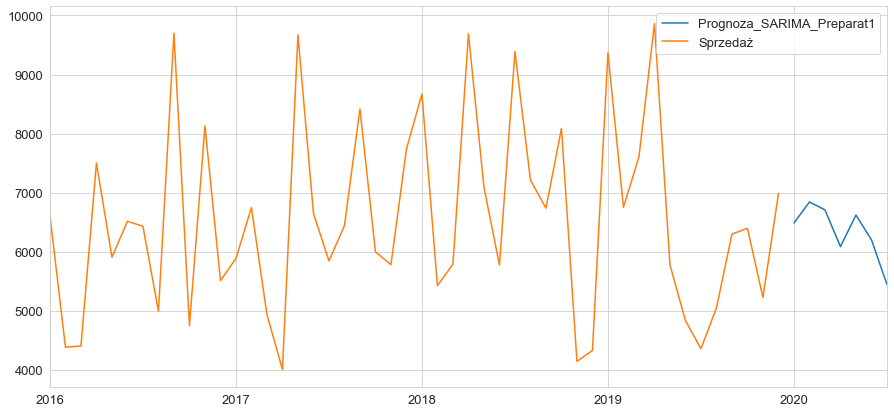

In [819]:
prognoza_plot=pd.DataFrame()
prognoza_plot['Prognoza_SARIMA_Preparat1']=predictions1
sns.set_style('whitegrid')
ax=prognoza_plot.plot(figsize=(15,7))
df1.Sprzedaż.plot(ax=ax, fontsize=13)
plt.legend(loc='best', prop={'size': 13})

# Prognoza preparatu 2 modelem Holta-Wintersa

In [852]:
model2 = ExponentialSmoothing(df2.Sprzedaż, trend='add', seasonal='add', seasonal_periods=12).fit()
predictions2 = model2.forecast(6)


<b>Wizualizacja prognozy<b>

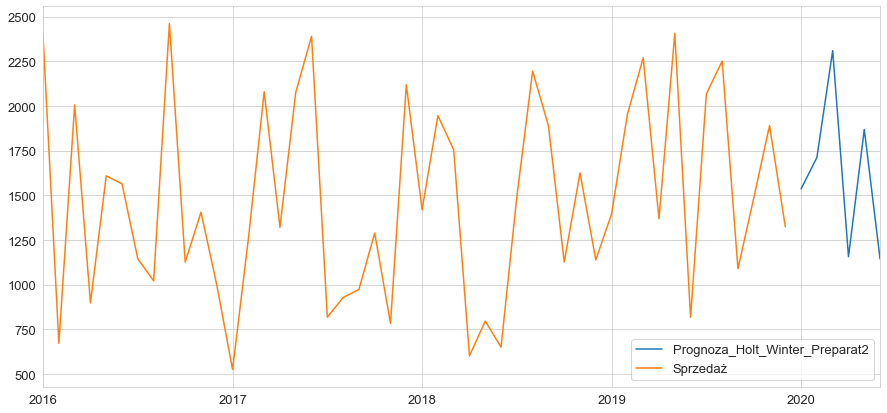

In [853]:
prognoza_plot=pd.DataFrame()
prognoza_plot['Prognoza_Holt_Winter_Preparat2']=np.expm1(predictions2)
sns.set_style('whitegrid')
ax=prognoza_plot.plot(figsize=(15,7))
np.expm1(df2.Sprzedaż).plot(ax=ax, fontsize=13)
plt.legend(loc='best', prop={'size': 13})

# Prognoza preparatu 3 modelem SARIMA

In [734]:
stepwise_fit = auto_arima(df3.Sprzedaż, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 10, random=True, n_iter=30, test='adf')        

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 12); AIC=82.394, BIC=95.345, Fit time=0.852 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=80.451, BIC=91.552, Fit time=0.486 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=84.386, BIC=99.187, Fit time=0.521 seconds
Fit ARIMA: order=(4, 1, 0) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 0, 1, 12); AIC=82.356, BIC=95.307, Fit time=0.373 seconds
Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 0, 1, 12); AIC=85.984, BIC=106.336, Fit time=1.011 seconds

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(1, 0, 1, 12)   Log Likelihood                 -34.226
Date:                            Fri, 27 Nov 2020   AIC                             80.451
Time:                                    21:57:41   BIC                             91.552
Sample:                                         0   HQIC                            84.629
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.136      0.892      -0.006       0.006
ma.L1         -0.8680     14.947     -0.058      0.954     -30.164      28.428
ma.L2         -0.1314      2.047     -0.064      0.949      -4.144       3.881
ar.S.L12       0.5869      1.093      0.537      0.591      -1.556       2.730
ma.S.L12      -0.9845     14.512     -0.068      0.946     -29.427      27.458
sigma2         0.1951      3.407      0.057      0.954      -6.482       6.872
===================================================================================
Ljung-Box (Q):                       29.06   Jarque-Bera (JB):                 3.24
Prob(Q):                              0.90   Prob(JB):                         0.20
Heteroskedasticity (H):               0.89   Skew:                            -0.43
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [854]:
model1 = SARIMAX(df3.Sprzedaż, order=(0,1,2) , seasonal_order=(1,0,1,12))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Sprzedaż   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(1, 0, 1, 12)   Log Likelihood                 -34.242
Date:                            Fri, 27 Nov 2020   AIC                             78.483
Time:                                    23:25:00   BIC                             87.734
Sample:                                01-31-2016   HQIC                            81.964
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8660      9.215     -0.094      0.925     -18.927      17.195
ma.L2         -0.1331      1.312     -0.101      0.919      -2.704       2.438
ar.S.L12       0.5876      1.065      0.552      0.581      -1.499       2.674
ma.S.L12      -0.9896     21.298     -0.046      0.963     -42.733      40.754
sigma2         0.1941      3.936      0.049      0.961      -7.519       7.908
===================================================================================
Ljung-Box (Q):                       28.65   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.91   Prob(JB):                         0.20
Heteroskedasticity (H):               0.90   Skew:                            -0.43
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [855]:
start = len(df3.Sprzedaż)
end = start +6
predictions3 = results1.predict(start,end, typ='levels').rename('SARIMA Prediction')

<b> Wizualizacja prognozy<b>

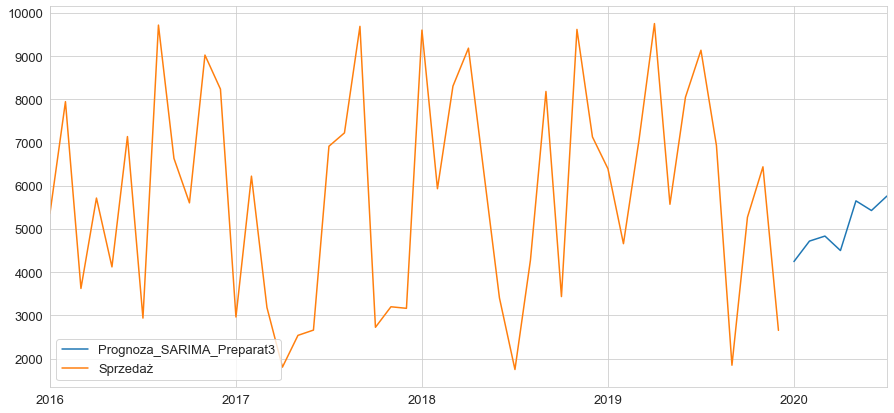

In [856]:
prognoza_plot=pd.DataFrame()
prognoza_plot['Prognoza_SARIMA_Preparat3']=np.expm1(predictions3)
sns.set_style('whitegrid')
ax=prognoza_plot.plot(figsize=(15,7))
np.expm1(df3.Sprzedaż).plot(ax=ax, fontsize=13)
plt.legend(loc='best', prop={'size': 13})

In [861]:
Prognozy = pd.DataFrame()
Prognozy['Preparat_1_SARIMA'] = predictions1
Prognozy['Preparat_2_Holt_Wintersint'] = predictions2
Prognozy['Preparat_3_SARIMA'] = predictions3
Prognozy.to_excel('Zadanie2_prognozy.xlsx')